<a href="https://colab.research.google.com/github/VMBoehm/NormalizingFlows/blob/master/Stepwise_Compression_RealNVP_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normalizing flow with dimensionality reduction
### stepwise dimensionality reduction






In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip
import corner

     - 11.0MB 1.0MB/s


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
import tensorflow_datasets as dts
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

In [0]:
import os

from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

PROJ = "My Drive/NormalizingFlow" 
PROJECT_PATH = os.path.join(ROOT, PROJ)
print(PROJECT_PATH)
if not os.path.isdir(PROJECT_PATH):
  os.makedirs(PROJECT_PATH)

module_dir= os.path.join(PROJECT_PATH, 'module/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/NormalizingFlow


In [0]:
nvp_func_path    = os.path.join(module_dir, 'nvp1/')
if not os.path.isdir(nvp_func_path):
  os.makedirs(nvp_func_path)
  
plot_path        = os.path.join(PROJECT_PATH, '/plots')

if not os.path.isdir(plot_path):
  os.makedirs(plot_path)

In [0]:
#mnist = tf.keras.datasets.fashion_mnist
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = (x_train/256.).reshape((-1,28*28))
x_test  = (x_test/256.).reshape((-1,28*28))

11493376/11490434 [==============================] - 0s 0us/step


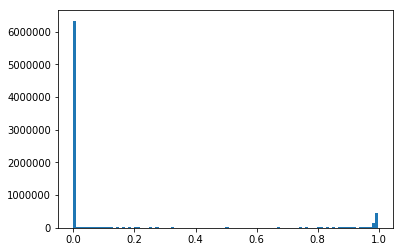

In [0]:
_= hist(x_test.flatten(),bins=100)

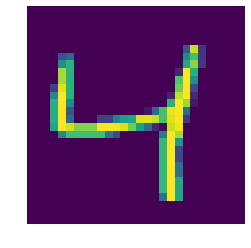

In [0]:
imshow(x_train[2].reshape((28,28)))
axis('off')
show()

define different data transforms

In [0]:
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA

class data_trafo():
  
  def __init__(self, types, params):
    
    self.types = types
    self.params= params
    
  def __call__(self,x):
    
    if 'dequantize':
      x = x + np.random.rand(*x.shape)/256.0
    
    if 'smooth' in self.types:
      for ii in range(len(x)):
        # overwrites, but that's ok, because we dont need the inverse
        x[ii]=gaussian_filter(x[ii].reshape((-1,28,28)), sigma=self.params['sigma']).flatten()    
    
    if 'mask' in self.types:
      try:
         x=x[:,self.mask]
      except:
        x, mask   = self.mask_data(x)
        self.mask = mask
          
    if 'shift_rescale' in self.types:
      x-=0.5
      x*=10
  
    if 'pca' in self.types:
      try:
        self.dec
      except:
        pca      = PCA(n_components=self.params['n_comp'])
        self.dec = pca.fit(x)
      x        = self.dec.transform(x)
      
      
    if 'logit_transform' in self.types:
      x = self.rescale(x,self.params['alpha'])
    
  
    if 'box_cox' in self.types:
      x, mean, mini = self.box_cox(x,self.params['lambda'])
      try:
        self.mini
      except:
        self.mini=mini
      try:
        self.mean
      except:
        self.mean=mean
      
    return x
  
  def inverse(self,y):
    
    if 'box_cox' in self.types:
      y = self.inverse_box_cox(y,self.mean, self.mini, self.params['lambda'])
    
    if 'logit_transform' in self.types:
      y = self.inverse_rescale(y,self.params['alpha'])
    
    if 'pca' in self.types:
      y = self.dec.inverse_transform(y)
      
    if 'shift_rescale' in self.types:
      y/=10
      y+=0.5   
    
    if 'mask' in self.types:
      y = self.inverse_mask(y)
           
    return y
  
  
  def mask_data(self,x):
    st_dev = x.std(axis=0)
    mask   = np.where(st_dev>5e-2)[0]
    y      = x[:,mask]
    return y, mask
  
  def inverse_mask(self,y):
    x = np.zeros((len(y),28*28))
    x[:,self.mask] = y
    return x
  
  
  def logit(self,x):
    return log(x/(1.-x))
  
  def inverse_logit(self,y):
    #=sigmoid
    return exp(y)/(exp(y)+1)
    
    
  def rescale(self,x,alpha):
    return self.logit((alpha+(1.-2.*alpha)*x))
  
  def inverse_rescale(self,y,alpha):
    return (((self.inverse_logit(y)-alpha)/(1.-2.*alpha)))
  
  
  def box_cox(self,x,l):
    minimum = np.amin(x)
    x = x-minimum*1.1
    x = (x**l-1.)/l
    mean = np.expand_dims(x.mean(),0)
    x-=mean
    return x, mean, minimum
  
  def inverse_box_cox(self,y,mean, minimum,l):
    y+=mean
    y = y*l+1.
    y = y**(1/l)
    y+=minimum*1.1
    return y
  

In [0]:
dt           = data_trafo(['dequantize','logit_transform'],{'sigma':1., 'lambda':1.4, 'n_comp':400, 'alpha':1e-6})
x_train_prep = dt(x_train)

In [0]:
x_test_prep = dt(x_test)

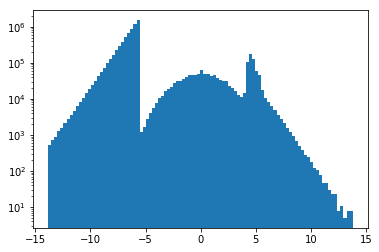

In [0]:
_= hist(x_test_prep.flatten(),bins=100, log=True)

In [0]:
import keras 
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
datagen = ImageDataGenerator(rotation_range=10)
datagen.fit(x_train_prep.reshape(-1,28,28,1))

In [0]:
data_dim    = x_train_prep.shape[-1]
batch_size  = 64
nvp_depth   = 10
nvp_dim     = 100
dim_red     = data_dim-nvp_dim
print(dim_red)

684


In [0]:
my_gen  = datagen.flow(x_train_prep.reshape(-1,28,28,1), batch_size=batch_size)

In [0]:
indices = np.arange(data_dim-dim_red)

getting checkerboard permutations

In [0]:
#get checkerboard
a = np.arange(0,data_dim,2)
b = np.arange(1,data_dim+1,2)

alternating_permutation = np.append(a,b)
print(alternating_permutation.shape)

#permute first and second half
a = np.arange(0,data_dim//2)
b = np.arange(data_dim//2,data_dim)
swapping_permutation = np.append(b,a)
print(swapping_permutation.shape)

np.random.seed(10101)

random_permutations = [np.random.permutation(np.arange(data_dim)) for ii in range(30)]

permutations = []
permutations.append(alternating_permutation)
for ii in range(len(random_permutations)):
  permutations.append(swapping_permutation)
  #permutations.append(random_permutations[ii])

(784,)
(784,)


In [0]:
tf.reset_default_graph()


lr            = tf.placeholder_with_default(0.01,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

sigma         = tf.placeholder_with_default(0.1,shape=[])




def get_prior():
    return tfd.MultivariateNormalDiag(tf.zeros([data_dim]), scale_identity_multiplier=1.0, name ='prior')

prior             = get_prior()

x_tr              = tf.placeholder(shape=[None,data_dim], dtype=tf.float32)



### ----------- NVP ----------- ###

def init_once(x, name):
  return tf.get_variable(name, initializer=x, trainable=False)


nvp_size      = [[1024, 1024] for ii in range(nvp_depth)]


class DimRed(tfb.Bijector):
  def __init__(self, input_dim, output_dim, batch_size,validate_args=False, name="dim_red"):
    super(DimRed, self).__init__(
        is_constant_jacobian=True,
        validate_args=validate_args,
        forward_min_event_ndims=output_dim,
        inverse_min_event_ndims=output_dim,
        name=name)
    print(input_dim,output_dim)
    self.is_injective = False
    self.indices      = tf.constant(np.arange(input_dim),dtype=tf.int32)
    self.shape        = tf.constant([output_dim,batch_size, 1])

  def _forward(self, x):
    return x

  def _inverse(self, y):    
    updates       = tf.gather(y,self.indices,axis=-1)
    updates       = tf.expand_dims(tf.transpose(updates),-1)
    y_comp        = tf.scatter_nd(tf.expand_dims(self.indices,-1), updates, self.shape)
    y_comp        = tf.squeeze(tf.transpose(y_comp))
    return y_comp

  def _inverse_log_det_jacobian(self, y):
    return tf.constant(0., y.dtype)

  def _forward_log_det_jacobian(self, x):
    return tf.constant(0., x.dtype)

 

def get_nvp():
  chain         = []
  perms         = [tfb.Permute(permutation=init_once(permutations[ii],name="permutation%d"%ii)) for ii in range(nvp_depth)]
  masked_frac   = 0.5
  
  
  current_dim = nvp_dim
  for i,s in enumerate(nvp_size):
    if i%2==0:
      chain.append(DimRed(input_dim=current_dim, output_dim=data_dim, batch_size=batch_size,name='red_dim%d'%i))
      current_dim = min(2*current_dim,data_dim)
    if i==0:
      chain.append(perms[i])
    mask_part   = np.int32(np.floor(data_dim*masked_frac))
    chain.append(tfb.RealNVP(num_masked=mask_part,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i,shift_only=True)))
    chain.append(perms[i])
                 
  return tfb.Chain(chain,name='nvp_chain')



def nvp_module_spec():
    x_sample     = tf.placeholder(tf.float32, shape=[None,data_dim])
    u_sample     = tf.placeholder(tf.float32, shape=[None,data_dim])

    nvp_         = get_nvp()
   
    bwd_pass     = nvp_.inverse(x_sample)
    fwd_pass     = nvp_.forward(u_sample)
    

    hub.add_signature(inputs={'x_sample':x_sample,'u_sample':u_sample},outputs={'fwd_pass': fwd_pass, 'bwd_pass': bwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)

nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

bwd_pass  = nvp_funcs({'x_sample':x_tr,'u_sample':np.zeros((batch_size,data_dim))},as_dict=True)['bwd_pass']
fwd_pass  = nvp_funcs({'x_sample':np.zeros((batch_size,data_dim)), 'u_sample':bwd_pass},as_dict=True)['fwd_pass']

likelihood = tfd.MultivariateNormalDiag(loc=fwd_pass, scale_identity_multiplier=sigma)

loss       = - tf.reduce_mean(likelihood.log_prob(x_tr))

opt_op_nvp = optimizer.minimize(loss)

# # ---------------------------end train nvp ----------------- #

#comment train nvp above section above and uncomment this for loading the trained module

#nvp_funcs     = hub.Module(nvp_func_path, trainable=False)

100 784
200 784
400 784
784 784
784 784
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Training of the NVP**

In [0]:
nvp_loss = []
nvp_sigma= []
nepoch = 0

In [0]:
ii     = 0

learning_rate = 1e-4

#train the nvp
while nepoch<400:
  x = my_gen.next()
  if len(x)==batch_size:
    if (ii+1)*batch_size>len(x_train_prep): 
      ii=0
      nepoch+=1
      print('starting epoch', nepoch)
    if nepoch>20:
      learning_rate=1e-4
    if nepoch>20:
      learning_rate=1e-5
    x_truth = x.reshape(-1,28*28)
    _, ll,s = sess.run([opt_op_nvp,loss,sigma], feed_dict={x_tr: x_truth, lr: learning_rate})
    nvp_loss+=[ll]
    nvp_sigma+=[s]
    if ii%100==0:
      print(ll, s)
  ii+=1

1472557.2 0.1


In [0]:
ll =[]
for ii in range(len(x_test_prep)//batch_size):
  ll.append(sess.run([loss], feed_dict={x_tr:x_test_prep[ii*batch_size:(ii+1)*batch_size]}))
print(mean(ll))

ll =[]
for ii in range(len(x_train_prep)//batch_size):
  ll.append(sess.run([loss], feed_dict={x_tr:x_train_prep[ii*batch_size:(ii+1)*batch_size]}))
print(mean(ll))

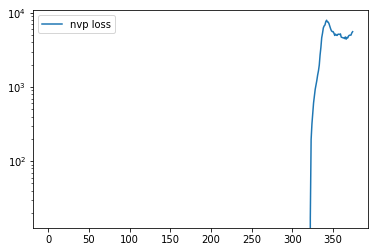

In [0]:
plt.figure()
semilogy(nvp_loss[::],label='nvp loss')
legend()

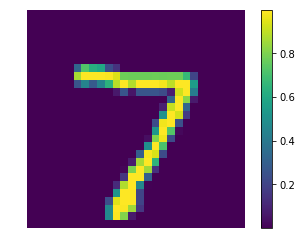

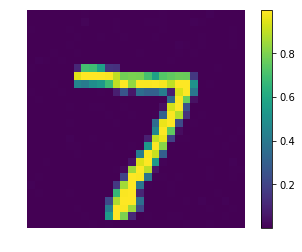

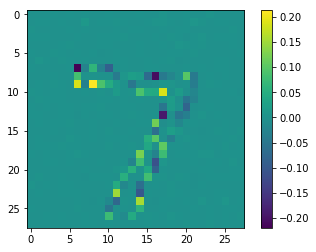

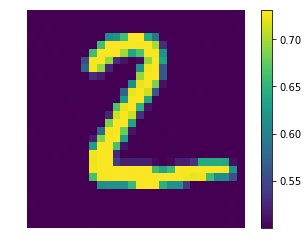

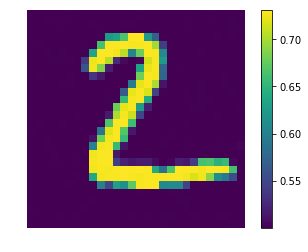

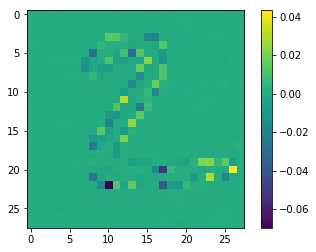

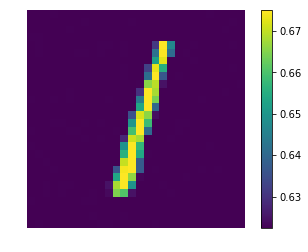

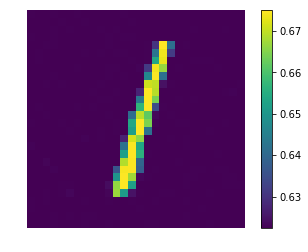

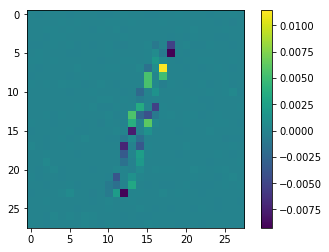

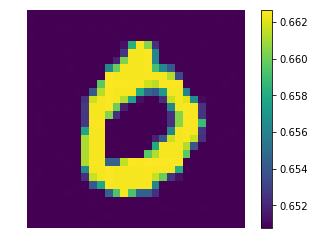

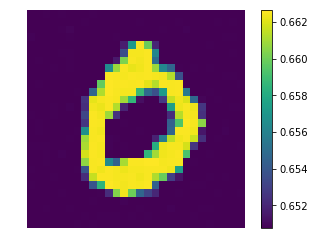

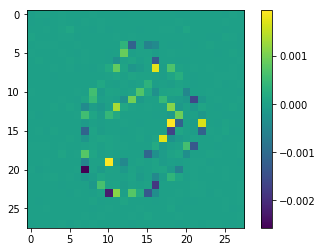

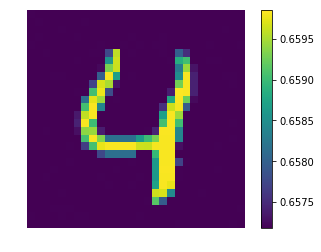

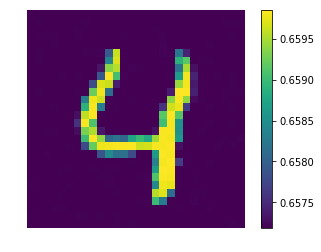

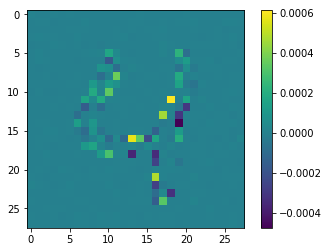

In [0]:
x_input = x_test_prep[:batch_size,:]

encode  = sess.run(bwd_pass, feed_dict={x_tr: x_input})
decode  = sess.run(fwd_pass, feed_dict={x_tr: x_input})

for index in range(5):

  x_input = dt.inverse(x_input)
  imshow(x_input[index].reshape((28,28)))
  axis('off')
  colorbar()
  show()

  decode = dt.inverse(decode)
  imshow(decode[index].reshape((28,28)))
  axis('off')
  colorbar()
  show()       

  imshow((decode[index]-x_input[index]).reshape((28,28)))
  colorbar()
  show()

In [0]:

prior_sample = sess.run(prior.sample(batch_size))
samples_nvp  = sess.run(nvp_funcs({'x_sample':x_truth,'u_sample':prior_sample},as_dict=True)['fwd_pass'])

data_space  = dt.inverse(samples_nvp)
print(data_space.shape)

figure(figsize=(5,5))
suptitle('nvp samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(data_space[i],(28,28)),cmap='gray',vmin=0,vmax=1); #colorbar()
    axis('off')

In [0]:
num = 20#len(x_test_prep)//batch_size
latent_space = np.zeros((num*batch_size,nvp_dim))
for ii in range(num):
  latent_space[ii*batch_size:(ii+1)*batch_size,:]=sess.run(nvp_funcs({'x_sample':x_test_prep[ii*batch_size:(ii+1)*batch_size],'u_sample':np.zeros((batch_size,nvp_dim))},as_dict=True)['bwd_pass'])


In [0]:
plt.scatter(latent_space[:,0],latent_space[:,1])

In [0]:
nvp_funcs.export(nvp_func_path,sess)